In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow as tf
from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
np.random.seed(1)

## 1. Obtain the MNIST dataset and normalize it for use with a classifier.

In [4]:
# The mnist dataset is already normalized
mnist = input_data.read_data_sets("./data/", one_hot=True)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


## 2. Select two different machine learning classification models

### A: Logistic regression

In [5]:
#https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/2_BasicModels/logistic_regression.ipynb

class LogisticRegression():
    def __init__(self, input_size, output_size, learning_rate=0.01, 
                 training_epochs= 100, batch_size=100, display_step=1):
        self.learning_rate = learning_rate
        self.training_epochs = training_epochs
        self.batch_size = batch_size
        self.display_step = display_step
        
        self.x = tf.placeholder(tf.float32, [None, input_size]) # mnist data image of shape 28*28=784
        self.y = tf.placeholder(tf.float32, [None, output_size]) # 0-9 digits recognition => 10 classes
        
        # Set model weights
        self.W = tf.Variable(tf.zeros([input_size, output_size]))
        self.b = tf.Variable(tf.zeros([output_size]))
        
        # Construct model
        self.pred = tf.nn.softmax(tf.matmul(self.x, self.W) + self.b)
        self.correct_pred = tf.equal(tf.argmax(self.pred, 1), tf.argmax(self.y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        
        # Minimize error using cross entropy
        self.loss = tf.reduce_mean(-tf.reduce_sum(self.y*tf.log(self.pred), reduction_indices=1))
               
        # Gradient Descent
        self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.loss)
        
        # Calculate loss with respect to input
        self.gradient_input = tf.gradients(self.loss, self.x)[0]
        
        # Initialize the variables (i.e. assign their default value)
        self.init = tf.global_variables_initializer()
        
    def fit(self, images, labels, sess = None):
        sessionCreated = False
        
        if sess is None:
            sess = tf.Session()
            sess.run(self.init)
            
            sessionCreated = True

        # Training cycle
        for epoch in range(self.training_epochs):
            avg_loss = 0.
            total_batch = int(len(images)/self.batch_size)

            # Loop over all batches
            for i in range(total_batch):
                batch_xs = images[i*self.batch_size: (i+1)*self.batch_size]
                batch_ys = labels[i*self.batch_size: (i+1)*self.batch_size]

                # Run optimization op (backprop) and loss op (to get loss value)
                _, acc, c = sess.run([self.optimizer, self.accuracy, self.loss], feed_dict={self.x: batch_xs,
                                                              self.y: batch_ys})
                # Compute average loss
                avg_loss += c / total_batch

            # Display logs per epoch step
            if self.display_step > 0 and (epoch+1) % self.display_step == 0:
                print "Epoch: {}, loss: {:.4f}, acc:{:.4f}".format(epoch+1, avg_loss, acc)
        
        if sessionCreated:
            sess.close()
            
    def measure_accuracy(self, images, labels, sess=None):
        sessionCreated = False
        
        if sess is None:
            sess = tf.Session()
            sess.run(self.init)
            
            sessionCreated = True
        
        print "Test accuracy:", sess.run(self.accuracy,
                                         feed_dict = {self.x:images, self.y:labels})
        
        
        if sessionCreated:
            sess.close()
            
    def get_adversarial_images(self, images, labels, sess=None):
        sessionCreated = False
        
        if sess is None:
            sess = tf.Session()
            sess.run(self.init)
            
            sessionCreated = True
        
        pred_y = []
        adv_x = []
        adv_y = []
        for index, [image, label] in enumerate(zip(images, labels)):
            pred, grad = sess.run([self.pred, self.gradient_input], feed_dict = {
                self.x:np.expand_dims(image, 0), self.y:np.expand_dims(label, 0)})

            adversarial_img_op = image + 0.2 * tf.sign(grad)
            adversarial_img = adversarial_img_op.eval(session=sess)
            
            ad_pred = sess.run(self.pred, feed_dict = {
                self.x:adversarial_img, self.y:np.expand_dims(label, 0)})
            
            pred_y.append(pred[0])
            adv_x.append(adversarial_img[0])
            adv_y.append(ad_pred[0])
                       
        if sessionCreated:
            sess.close()
            
        return pred_y, adv_x, adv_y

### B: Convolutional Neural Network

In [8]:
# REF: https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/convolutional_network_raw.ipynb
class CNN():
    def __init__(self, input_size, output_size, learning_rate=0.001, 
                 training_epochs= 1, batch_size=200, dropout=0.75, display_step=10):
        self.learning_rate = learning_rate
        self.training_epochs = training_epochs
        self.batch_size = batch_size
        self.display_step = display_step
        self.dropout = dropout
        
        self.x = tf.placeholder(tf.float32, [None, input_size])
        self.y = tf.placeholder(tf.float32, [None, output_size])
        self.keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)
        
        # Create some wrappers for simplicity
        def conv2d(x, W, b, strides=1):
            # Conv2D wrapper, with bias and relu activation
            x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
            x = tf.nn.bias_add(x, b)
            return tf.nn.relu(x)


        def maxpool2d(x, k=2):
            # MaxPool2D wrapper
            return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                                  padding='SAME')


        # Create model
        def conv_net(x, weights, biases, dropout):
            # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
            # Reshape to match picture format [Height x Width x Channel]
            # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
            x = tf.reshape(x, shape=[-1, 28, 28, 1])

            # Convolution Layer
            conv1 = conv2d(x, weights['wc1'], biases['bc1'])
            # Max Pooling (down-sampling)
            conv1 = maxpool2d(conv1, k=2)

            # Convolution Layer
            conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
            # Max Pooling (down-sampling)
            conv2 = maxpool2d(conv2, k=2)

            # Fully connected layer
            # Reshape conv2 output to fit fully connected layer input
            fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
            fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
            fc1 = tf.nn.relu(fc1)
            # Apply Dropout
            fc1 = tf.nn.dropout(fc1, dropout)

            # Output, class prediction
            out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
            return out
        
        # Store layers weight & bias
        self.weights = {
            # 5x5 conv, 1 input, 32 outputs
            'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
            # 5x5 conv, 32 inputs, 64 outputs
            'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
            # fully connected, 7*7*64 inputs, 1024 outputs
            'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
            # 1024 inputs, 10 outputs (class prediction)
            'out': tf.Variable(tf.random_normal([1024, output_size]))
        }

        self.biases = {
            'bc1': tf.Variable(tf.random_normal([32])),
            'bc2': tf.Variable(tf.random_normal([64])),
            'bd1': tf.Variable(tf.random_normal([1024])),
            'out': tf.Variable(tf.random_normal([output_size]))
        }
        
        # Construct model
        self.logits = conv_net(self.x, self.weights, self.biases, self.keep_prob)
        self.prediction = tf.nn.softmax(self.logits)

        # Define loss and optimizer
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, labels=self.y))

        # Calculate loss with respect to input
        self.gradient_input = tf.gradients(self.loss_op, self.x)[0]

        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss_op)


        # Evaluate model
        self.correct_pred = tf.equal(tf.argmax(self.prediction, 1), tf.argmax(self.y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        # Initialize the variables (i.e. assign their default value)
        self.init = tf.global_variables_initializer()

        
    def fit(self, images, labels, sess = None):
        sessionCreated = False
        
        if sess is None:
            sess = tf.Session()
            sess.run(self.init)
            
            sessionCreated = True

        # Training cycle
        for step in range(1, self.training_epochs+1):
            total_batch = int(len(images)/self.batch_size)
            
            # Loop over all batches
            for i in range(total_batch):
                batch_x = images[i*self.batch_size: (i+1)*self.batch_size]
                batch_y = labels[i*self.batch_size: (i+1)*self.batch_size]
            
                # Run optimization op (backprop)
                sess.run(self.train_op, feed_dict={self.x: batch_x, self.y: batch_y, self.keep_prob: self.dropout})
            
                count = step*i
                if self.display_step>0 and (count % self.display_step == 0 or count == 1):
                    # Calculate batch loss and accuracy
                    loss, acc = sess.run([self.loss_op, self.accuracy], feed_dict={self.x: batch_x,
                                                                         self.y: batch_y,
                                                                         self.keep_prob: 1.0})
                    print "Epoch: {}, loss: {:.4f}, acc:{:.4f}".format(count, loss, acc)
        
        if sessionCreated:
            sess.close()
            
    def measure_accuracy(self, images, labels, sess=None):
        sessionCreated = False
        
        if sess is None:
            sess = tf.Session()
            sess.run(self.init)
            
            sessionCreated = True
        
        print "Test accuracy:", sess.run(self.accuracy,
                 feed_dict = {self.x:images[0:256],
                              self.y:labels[0:256], self.keep_prob: 1.0})
        
        
        if sessionCreated:
            sess.close()
            
    def get_adversarial_images(self, images, labels, sess=None):
        sessionCreated = False
        
        if sess is None:
            sess = tf.Session()
            sess.run(self.init)
            
            sessionCreated = True
        
        pred_y = []
        adv_x = []
        adv_y = []
        for index, [image, label] in enumerate(zip(images, labels)):
            pred, grad = sess.run([self.prediction, self.gradient_input], feed_dict = {
                self.x:np.expand_dims(image, 0), self.y:np.expand_dims(label, 0), self.keep_prob: 1.0})

            adversarial_img_op = image + 0.2 * tf.sign(grad)
            adversarial_img = adversarial_img_op.eval(session=sess)
            
            ad_pred = sess.run(self.prediction, feed_dict = {
                self.x:adversarial_img, self.y:np.expand_dims(label, 0), self.keep_prob: 1.0})
            
            pred_y.append(pred[0])
            adv_x.append(adversarial_img[0])
            adv_y.append(ad_pred[0])
                       
        if sessionCreated:
            sess.close()
            
        return pred_y, adv_x, adv_y

#### C: Random forest (Did not use this for adversarial example because tf.gradients(...) throws error for tensor_forest)

In [9]:
# https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/2_BasicModels/random_forest.py

class RandomForest():
    def __init__(self, input_size, output_size, training_epochs= 500,
                 batch_size=1024, num_trees=10, max_nodes = 1000, display_step=1):
        self.training_epochs = training_epochs
        self.batch_size = batch_size
        self.num_trees = num_trees
        self.max_nodes = max_nodes
        self.display_step = display_step
        
        # Input and Target data
        self.x = tf.placeholder(tf.float32, shape=[None, input_size])
        # For random forest, labels must be integers (the class id)
        self.y = tf.placeholder(tf.int32, shape=[None])
        
        # Random Forest Parameters
        self.hparams = tensor_forest.ForestHParams(num_classes=output_size,
                                      num_features=input_size,
                                      num_trees=self.num_trees,
                                      max_nodes=self.max_nodes).fill()
        
        # Build the Random Forest
        self.forest_graph = tensor_forest.RandomForestGraphs(self.hparams)
        # Get training graph and loss
        self.train = self.forest_graph.training_graph(self.x, self.y)
        self.loss = self.forest_graph.training_loss(self.x, self.y)

        # Measure the accuracy
        self.infer, _, _ = self.forest_graph.inference_graph(self.x)
        self.correct_pred = tf.equal(tf.argmax(self.infer, 1), tf.cast(self.y, tf.int64))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        # Initialize the variables (i.e. assign their default value) and forest resources
        self.init = tf.group(tf.global_variables_initializer(),
            resources.initialize_resources(resources.shared_resources()))

    
    def fit(self, sess = None):
        sessionCreated = False
        
        if sess is None:
            sess = tf.Session()
            sess.run(self.init)
            
            sessionCreated = True

        # Training
        for i in range(1, self.training_epochs + 1):
            # Prepare Data
            # Get the next batch of MNIST data (only images are needed, not labels)
            batch_x, batch_y = mnist.train.next_batch(self.batch_size)
            _, l = sess.run([self.train, self.loss], feed_dict={self.x: batch_x, self.y: np.argmax(batch_y, axis=1)})
            
            if self.display_step >0 and (i % self.display_step == 0 or i == 1):
                acc = sess.run(self.accuracy, feed_dict={self.x: batch_x, self.y: np.argmax(batch_y, axis=1)})
                print "Step {}, loss: {:.4f}, acc: {:.4f}".format(i+1, l, acc)

        
        if sessionCreated:
            sess.close()
            
    def measure_accuracy(self, sess=None):
        sessionCreated = False
        
        if sess is None:
            sess = tf.Session()
            sess.run(self.init)
            
            sessionCreated = True
        
        print "Test accuracy:", sess.run(self.accuracy,feed_dict = {self.x:mnist.test.images, self.y:np.argmax(mnist.test.labels, axis=1)})
        
        
        if sessionCreated:
            sess.close()

## 3. Train both models and achieve a "decent" testing accuracy (over 90%)

### A: Logistic regression

In [11]:
clf_reg = LogisticRegression(mnist.train.images.shape[1], 10, training_epochs=25, display_step=0)

with tf.Session() as sess:
    # Run the initializer
    sess.run(clf_reg.init)
    
    clf_reg.fit(mnist.train.images, mnist.train.labels, sess)
    clf_reg.measure_accuracy(mnist.test.images, mnist.test.labels, sess)

Test accuracy: 0.9145


### B: Convolutional Neural Network

In [12]:
clf_cnn = CNN(mnist.train.images.shape[1], 10, display_step=0)

with tf.Session() as sess:
    # Run the initializer
    sess.run(clf_cnn.init)
    
    clf_cnn.fit(mnist.train.images, mnist.train.labels, sess)
    clf_cnn.measure_accuracy(mnist.test.images, mnist.test.labels, sess)

Test accuracy: 0.95703125


#### C: Random forest

In [10]:
clf_rf = RandomForest(mnist.train.images.shape[1], 10, training_epochs=500, display_step=0)
with tf.Session() as sess:
    # Run the initializer
    sess.run(clf_rf.init)
    
    clf_rf.fit(sess)
    clf_rf.measure_accuracy(sess)

INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:{'num_output_columns': 11, 'feature_bagging_fraction': 1.0, 'valid_leaf_threshold': 1, 'checkpoint_stats': False, 'initialize_average_splits': False, 'pruning_type': 0, 'prune_every_samples': 0, 'dominate_fraction': 0.99, 'max_fertile_nodes': 0, 'early_finish_check_every_samples': 0, 'dominate_method': 'bootstrap', 'bagging_fraction': 1.0, 'regression': False, 'param_file': None, 'bagged_num_features': 784, 'use_running_stats_method': False, 'max_nodes': 1000, 'split_finish_name': 'basic', 'leaf_model_type': 0, 'stats_model_type': 0, 'bagged_features': None, 'num_features': 784, 'split_after_samples': 250, 'num_outputs': 1, 'collate_examples': False, 'split_type': 0, 'num_classes': 10, 'num_splits_to_consider': 28.0, 'split_name': 'less_or_equal', 'finish_type': 0, 'inference_tree_paths': False, 'split_pruning_name': 'none', 'base_random_seed': 0, 'num_trees': 10, 'model_name': 'all_dense'}
Test accuracy: 0.9243


## 4.  Generate 100 adversarial examples for each model

From the adversarial examples generated using both the models, we can see that Logistic regression model generates better adversarial examples compared to Convolutional Neural Network. In case of CNN we get higher accuracy for the test dataset. However, due to vanishing gradient, CNN causes no change to to input image based on which adversarial examples are generated.

Adversarial examples in case of CNN can be generated using very small number of epochs and training data. In that case the model is not trained well and it's prediction is not good for neither orginal image nor the adversarial example.

In [13]:
# Helper function for visualization

def show_images(images, labels, n, title="Label"):
    plt.figure(figsize=(20,4))
    for index, (image, label) in enumerate(zip(images[0:n], labels[0:n])):
        plt.subplot(1, n, index + 1)
        plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
        plt.title('%s: %i\n' % (title, label), fontsize = 12)
    plt.show()
    
def show_proba(images, labels, probabilities, n, title="Label"):
    plt.figure(figsize=(20,4))
    for index, (image, label, proba) in enumerate(zip(images[0:n], labels[0:n], probabilities[0:n])):
        plt.subplot(1, n, index + 1)
        
        #y_proba = classifier.predict_proba([image])[0]
        plt.bar(np.arange(10), proba)
        
        # print y_proba
        plt.title('%s: %i\n' % (title, label), fontsize = 12)
    plt.show()

### A: Logistic regression

##### Generate 100 examples

In [14]:
clf_reg = LogisticRegression(mnist.train.images.shape[1], 10, training_epochs=25, display_step=0)
with tf.Session() as sess:
    # Run the initializer
    sess.run(clf_reg.init)
    
    clf_reg.fit(mnist.train.images, mnist.train.labels, sess)
    reg_pred_y, reg_adv_x, reg_adv_y = clf_reg.get_adversarial_images(mnist.test.images[0:100],
                              mnist.test.labels[0:100], sess=sess)

##### Visualize 5 for analysis

##### Actual labels

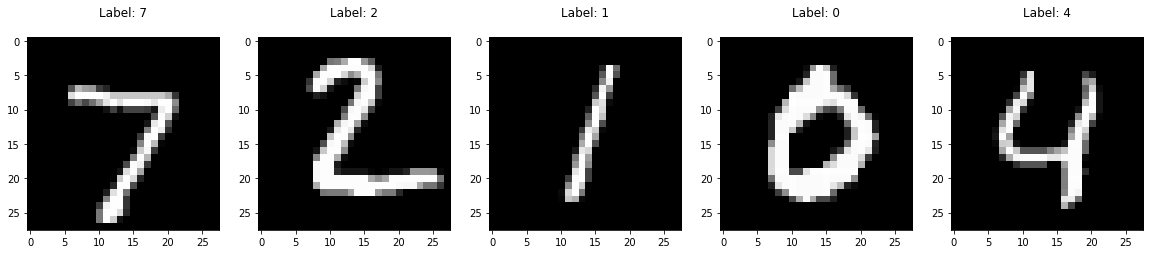

In [15]:
show_images(mnist.test.images, np.argmax(mnist.test.labels, axis=1), 5)

##### Predicted labels

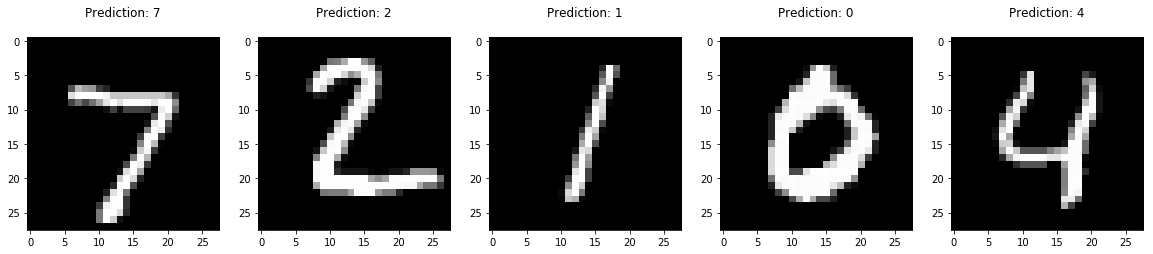

In [16]:
show_images(mnist.test.images[0:100], np.argmax(reg_pred_y, axis=1), 5, title="Prediction")

##### Adversarial images with predicted labels

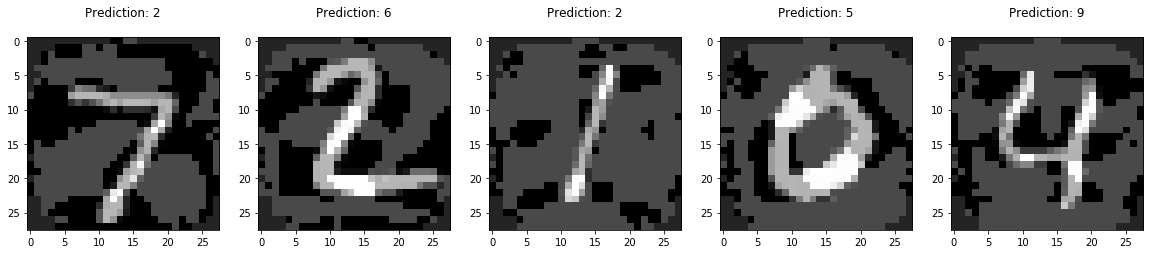

In [17]:
show_images(reg_adv_x, np.argmax(reg_adv_y, axis=1), 5, title="Prediction")

##### Probability for original images

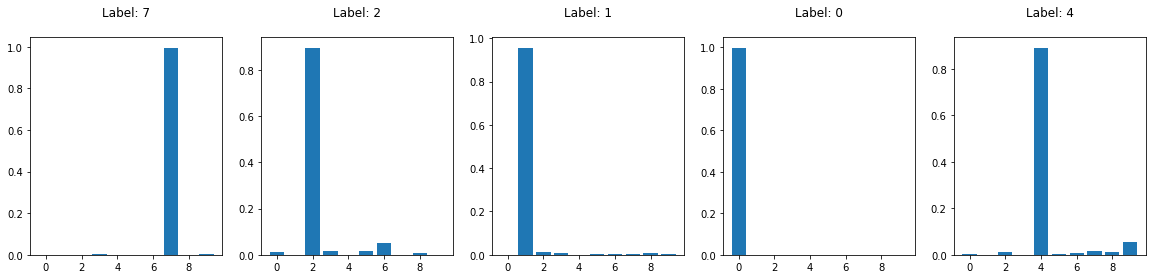

In [18]:
show_proba(mnist.test.images[0:100], np.argmax(mnist.test.labels[0:100], axis=1), reg_pred_y, 5)

##### Probability for adversarial images

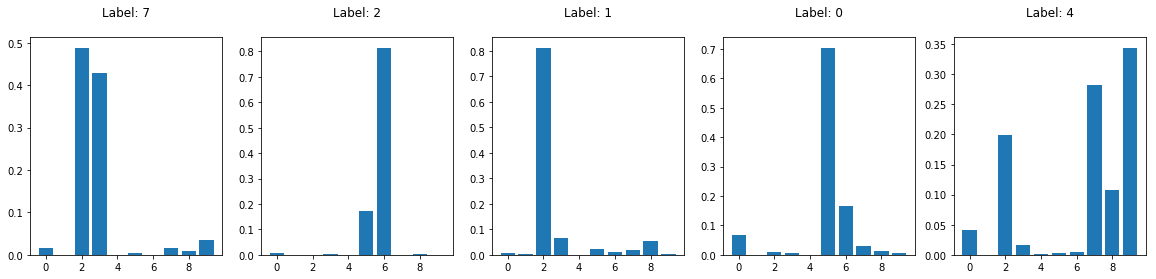

In [19]:
show_proba(reg_adv_x, np.argmax(mnist.test.labels[0:100], axis=1), reg_adv_y, 5)

##### Accuracy for the adversarial images

In [21]:
clf_reg = LogisticRegression(mnist.train.images.shape[1], 10, training_epochs=25, display_step=0)

with tf.Session() as sess:
    # Run the initializer
    sess.run(clf_reg.init)
    
    clf_reg.fit(mnist.train.images, mnist.train.labels, sess)
    
    print "Adversarial accuracy:", sess.run(clf_reg.accuracy,
                    feed_dict = {clf_reg.x:reg_adv_x, clf_reg.y:mnist.test.labels[0:100]})

Adversarial accuracy: 0.0


### B: Convolutional Neural Network

##### Generate 100 examples

In [23]:
clf_cnn = CNN(mnist.train.images.shape[1], 10, training_epochs=1, display_step=0)

with tf.Session() as sess:
    # Run the initializer
    sess.run(clf_cnn.init)
    
    clf_cnn.fit(mnist.train.images[0:2000], mnist.train.labels[0:2000], sess)
    cnn_pred_y, cnn_adv_x, cnn_adv_y = clf_cnn.get_adversarial_images(mnist.test.images[0:100],
                              mnist.test.labels[0:100], sess=sess)

##### Visualize 5 for analysis

#### Actual labels

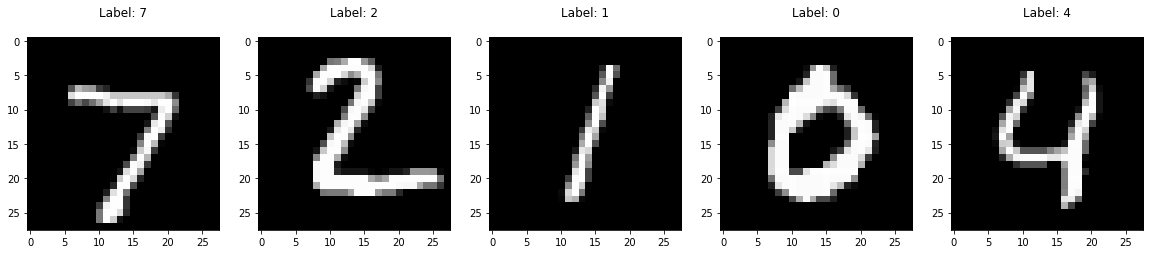

In [24]:
show_images(mnist.test.images[0:100], np.argmax(mnist.test.labels, axis=1), 5)

##### Predicted labels

Most predictions are poor because the network was intentionaly trained with less data and for few epochs to generate adversarial examples

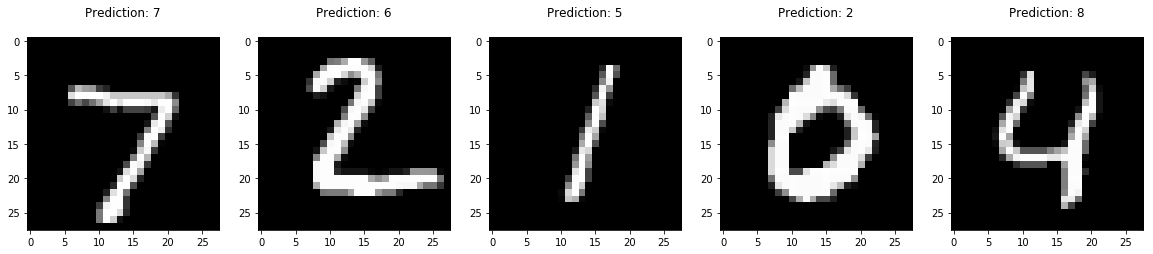

In [25]:
show_images(mnist.test.images[0:100], np.argmax(cnn_pred_y, axis=1), 5, title="Prediction")

##### Adversarial images with predicted labels

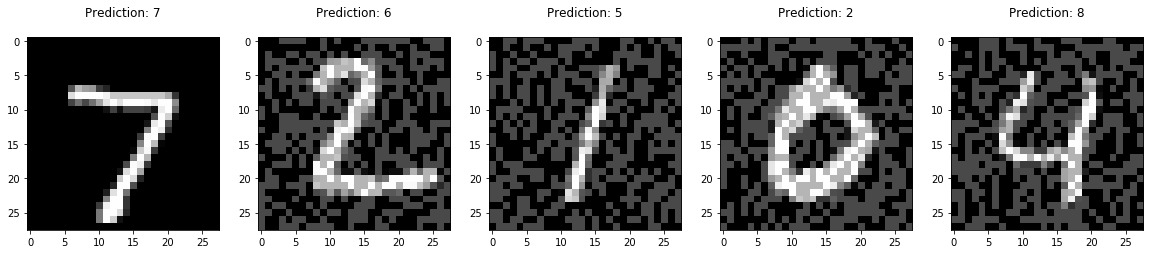

In [26]:
show_images(cnn_adv_x, np.argmax(cnn_adv_y, axis=1), 5, title="Prediction")

##### Probability for original image

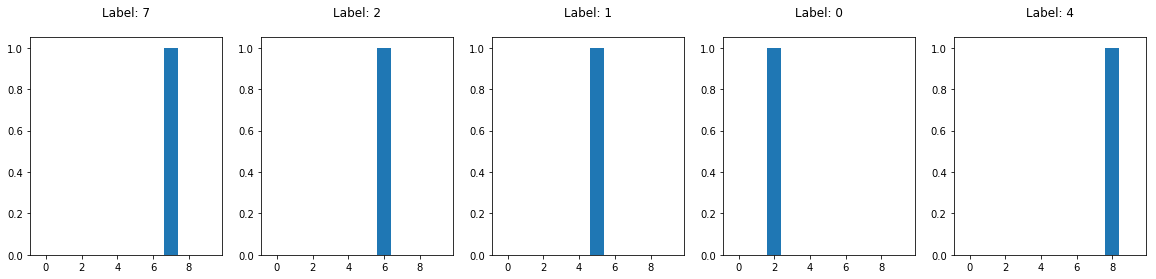

In [27]:
show_proba(mnist.test.images[0:100], np.argmax(mnist.test.labels[0:100], axis=1), cnn_pred_y, 5)

##### Probability for adversarial images

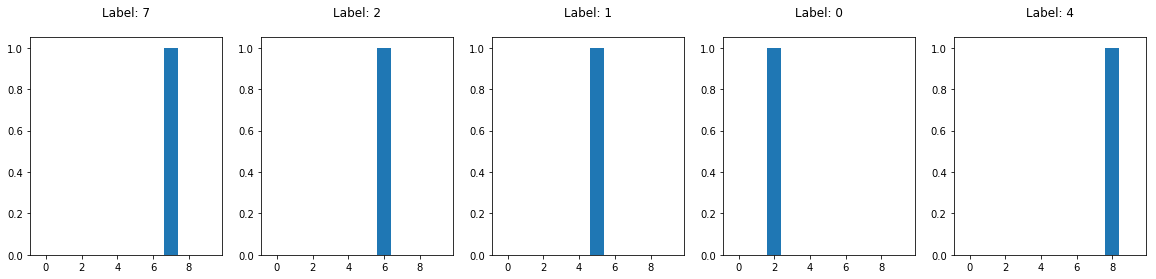

In [28]:
show_proba(cnn_adv_x, np.argmax(mnist.test.labels[0:100], axis=1), cnn_adv_y, 5)

##### Accuracy for the adversarial images

In [30]:
clf_cnn = CNN(mnist.train.images.shape[1], 10, display_step=0)

with tf.Session() as sess:
    # Run the initializer
    sess.run(clf_cnn.init)
    
    clf_cnn.fit(mnist.train.images, mnist.train.labels, sess)
    
    print "Adversarial accuracy:", sess.run(clf_cnn.accuracy,
                    feed_dict = {clf_cnn.x:cnn_adv_x, 
                                 clf_cnn.y:mnist.test.labels[0:100], clf_cnn.keep_prob: 1.0})

Adversarial accuracy: 0.78


## 5. Use the adversarial examples of A with model B and of B with model A

The accuracy value below shows that the adversarial examples of Logistic regression fools Convolutional Neural Network but not vice versa. In the previous section we also found that accuracy of CNN for adversarial examples generated by itself is 78% whereas accuracy of Logistic regression for it's adversarial examples is zero.

### Adversarial examples of Convolutional Neural Network used with Logistic regression

In [32]:
clf_reg = LogisticRegression(mnist.train.images.shape[1], 10, training_epochs=25, display_step=0)

with tf.Session() as sess:
    # Run the initializer
    sess.run(clf_reg.init)
    
    clf_reg.fit(mnist.train.images, mnist.train.labels, sess)
    
    print "Adversarial accuracy:", sess.run(clf_reg.accuracy,
                    feed_dict = {clf_reg.x:cnn_adv_x, clf_reg.y:mnist.test.labels[0:100]})

Adversarial accuracy: 0.95


### Adversarial examples of Logistic regression used with Convolutional Neural Network

In [34]:
clf_cnn = CNN(mnist.train.images.shape[1], 10, display_step=0)

with tf.Session() as sess:
    # Run the initializer
    sess.run(clf_cnn.init)
    
    clf_cnn.fit(mnist.train.images, mnist.train.labels, sess)
    
    print "Adversarial accuracy:", sess.run(clf_cnn.accuracy,
                    feed_dict = {clf_cnn.x:reg_adv_x, 
                                 clf_cnn.y:mnist.test.labels[0:100], clf_cnn.keep_prob: 1.0})

Adversarial accuracy: 0.22


## 6. Generate new adversarial examples and evaluate

### Generate new examples using Logistic regression

We used 1000 adversarial examples to reduce processing time

In [ ]:
new_images = []
new_labels = []

clf_reg = LogisticRegression(mnist.train.images.shape[1], 10, training_epochs=25, display_step=0)

with tf.Session() as sess:
    # Run the initializer
    sess.run(clf_reg.init)
    
    clf_reg.fit(mnist.train.images, mnist.train.labels, sess)

    for index, [image, label] in enumerate(zip(mnist.train.images[0:1000], mnist.train.labels[0:1000])):
        new_images.append(image)
        new_labels.append(label)
    
    for index, [image, label] in enumerate(zip(mnist.train.images, mnist.train.labels)):
        grad = sess.run([clf_reg.gradient_input], feed_dict = {
            clf_reg.x:np.expand_dims(image, 0), clf_reg.y:np.expand_dims(label, 0)})
        
        
        adversarial_img_op = image + 0.2 * tf.sign(grad[0])
        adversarial_img = adversarial_img_op.eval(session=sess)


        new_images.append(adversarial_img[0])
        new_labels.append(label)

### Evaluation with new adversarial examples

#### Logistic regression

In [51]:
clf_reg = LogisticRegression(mnist.train.images.shape[1], 10, training_epochs=25, display_step=0)

with tf.Session() as sess:
    # Run the initializer
    sess.run(clf_reg.init)
    
    clf_reg.fit(new_images, new_labels, sess)
    clf_reg.measure_accuracy(mnist.test.images, mnist.test.labels, sess)

Test accuracy: 0.9069


#### Convolutional Neural Network

In [52]:
clf_cnn = CNN(mnist.train.images.shape[1], 10, display_step=0)

with tf.Session() as sess:
    # Run the initializer
    sess.run(clf_cnn.init)
    
    clf_cnn.fit(new_images, new_labels, sess)
    clf_cnn.measure_accuracy(mnist.test.images, mnist.test.labels, sess)

Test accuracy: 0.91015625


- The evaluation above shows that the classification accuracy decreases for both the models in case of adversarial examples added in training set. This happens because the models tend to overfit.

- The model is less susceptible to adversarial examples after training with new examples.

- Yes we can do regularization to avoid overfitting. The CNN model uses dropout for regularization.